### About the data set (Bank Client Data)

#### Bank client data:
**age:** Age of the client<br>
**duration:** last contact duration, in seconds.<br> 

#### Other attributes:
**campaign:** number of contacts performed during this campaign and for this client<br>
**pdays:** number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted)<br>
**previous:** number of contacts performed before this campaign and for this client<br>

#### Social and economic context attributes
**emp.var.rate:** employment variation rate - quarterly indicator<br>
**cons.price.idx:** consumer price index - monthly indicator<br>
**cons.conf.idx:** consumer confidence index - monthly indicator<br>
**euribor3m:** euribor 3 month rate - daily indicator<br>
**nr.employed:** number of employees - quarterly indicator<br>

**y** - (Output variable) has the client subscribed a term deposit?

Data citation: [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

## Table of Content

1. **[Data Preprocessing](#dp)**
1. **[K Nearest Neighbors (KNN)](#knn)**
2. **[Naive Bayes](#nb)**

**Import the required libraries**

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, accuracy_score
from warnings import filterwarnings
filterwarnings('ignore')

#### Load the csv file

In [2]:
df=pd.read_csv('bank.csv')
df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,32,205,2,999,0,1.1,93.994,-36.4,4.858,5191.0,no
1,32,691,10,999,0,1.4,93.918,-42.7,4.960,5228.1,yes
2,45,45,8,999,0,1.4,93.444,-36.1,4.963,5228.1,no
3,33,400,1,5,2,-1.1,94.601,-49.5,1.032,4963.6,yes
4,47,903,2,999,1,-1.8,93.075,-47.1,1.415,5099.1,yes


<a id="dp"> </a>
## 1. Data Preprocessing

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>1. Remove the outliers (if any).</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [3]:
df.shape

(9640, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9640 entries, 0 to 9639
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             9640 non-null   int64  
 1   duration        9640 non-null   int64  
 2   campaign        9640 non-null   int64  
 3   pdays           9640 non-null   int64  
 4   previous        9640 non-null   int64  
 5   emp.var.rate    9640 non-null   float64
 6   cons.price.idx  9640 non-null   float64
 7   cons.conf.idx   9640 non-null   float64
 8   euribor3m       9640 non-null   float64
 9   nr.employed     9640 non-null   float64
 10  y               9640 non-null   object 
dtypes: float64(5), int64(5), object(1)
memory usage: 828.6+ KB


In [5]:
df.isnull().sum()

age               0
duration          0
campaign          0
pdays             0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

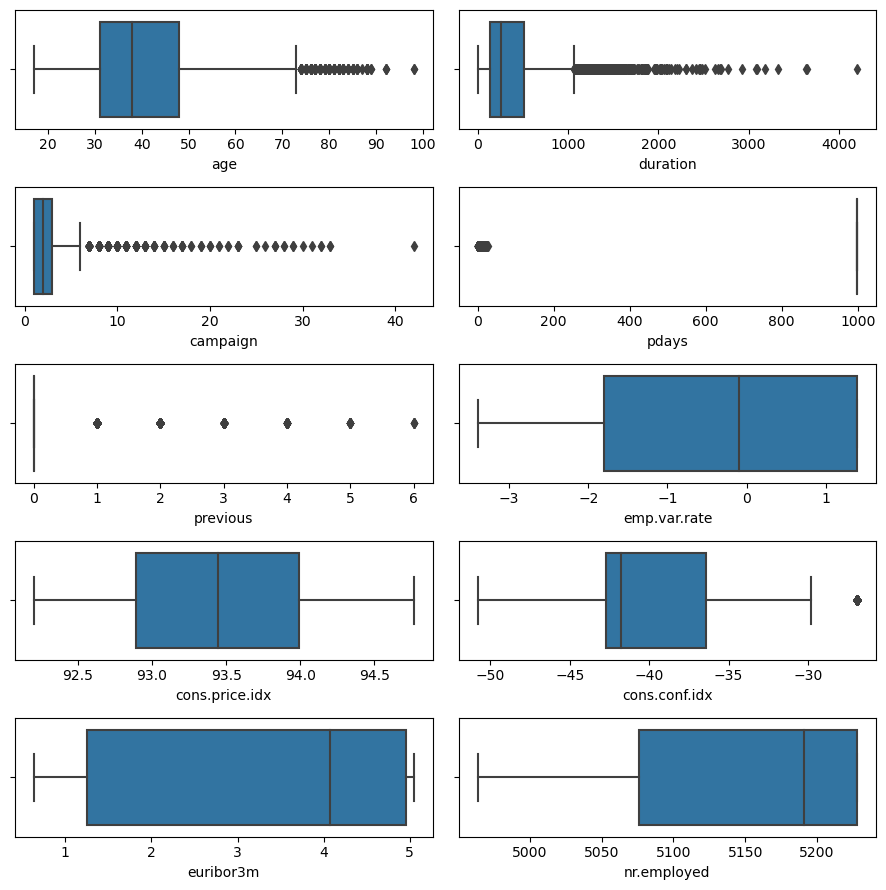

In [6]:
fig, ax = plt.subplots(5, 2, figsize=(9, 9))

for variable, subplot in zip(df, ax.flatten()):
    boxplt = sns.boxplot(x=df[variable], ax=subplot)
    boxplt.set_xlabel(variable, fontsize = 10)
    
plt.tight_layout()   
plt.show() 

In [7]:
q1=df.quantile(0.25)
q3=df.quantile(0.75)
IQR=q3-q1
lower=q1-1.5*IQR
upper=q3+1.5*IQR

In [8]:
df=df[~((df<lower) | (df>upper)).any(axis=1)]
df

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,32,205,2,999,0,1.1,93.994,-36.4,4.858,5191.0,no
5,25,243,3,999,0,-1.8,92.843,-50.0,1.531,5099.1,yes
6,36,214,1,999,0,-0.1,93.200,-42.0,4.120,5195.8,no
7,43,550,1,999,0,1.1,93.994,-36.4,4.857,5191.0,no
8,52,64,1,999,0,1.1,93.994,-36.4,4.855,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...
9634,30,475,5,999,0,-3.4,92.379,-29.8,0.781,5017.5,yes
9635,37,854,3,999,0,1.4,94.465,-41.8,4.961,5228.1,no
9636,40,353,2,999,0,1.4,93.918,-42.7,4.960,5228.1,no
9638,39,233,1,999,0,1.4,94.465,-41.8,4.864,5228.1,no


In [9]:
df.reset_index(drop=True, inplace=True)

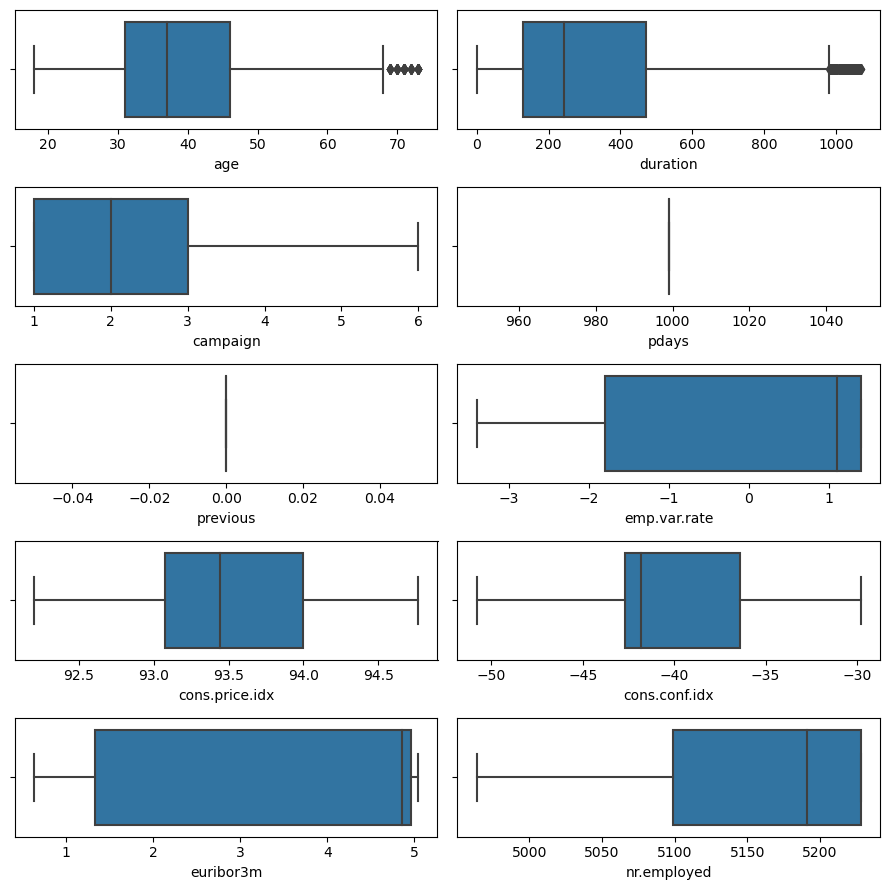

In [10]:
fig, ax = plt.subplots(5, 2, figsize=(9, 9))

for variable, subplot in zip(df, ax.flatten()):
    boxplt = sns.boxplot(x=df[variable], ax=subplot)
    boxplt.set_xlabel(variable, fontsize = 10)
    
plt.tight_layout()   
plt.show() 

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>2. Separate the dependent and the independent variables. Also, in the target variable, replace no with 0 and yes with 1.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [11]:
df['y']=pd.get_dummies(df['y'],drop_first=True)
df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,32,205,2,999,0,1.1,93.994,-36.4,4.858,5191.0,0
1,25,243,3,999,0,-1.8,92.843,-50.0,1.531,5099.1,1
2,36,214,1,999,0,-0.1,93.200,-42.0,4.120,5195.8,0
3,43,550,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
4,52,64,1,999,0,1.1,93.994,-36.4,4.855,5191.0,0


<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>3. Replace the value "unknown" from each column with NaN.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [12]:
unknown_exists = (df == 'unknown').any()
unknown_exists

age               False
duration          False
campaign          False
pdays             False
previous          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

In [13]:
df.replace(['unknown',np.NaN], inplace=True)

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>4. Look for the null values and treat the null values.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [14]:
df.isnull().sum()

age               0
duration          0
campaign          0
pdays             0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>5. Remove the unnecessary variables that will not contribute to the model.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [15]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,6555.000000,6555.000000,6555.000000,6555.0,6555.0,6555.000000,6555.000000,6555.000000,6555.000000,6555.000000,6555.000000
mean,39.360946,326.819680,2.031426,999.0,0.0,-0.040976,93.555595,-40.643051,3.495618,5161.670618,0.381388
std,10.184894,253.406706,1.283539,0.0,0.0,1.626927,0.585132,4.659679,1.779666,74.431765,0.485765
min,18.000000,0.000000,1.000000,999.0,0.0,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,31.000000,130.000000,1.000000,999.0,0.0,-1.800000,93.075000,-42.700000,1.334000,5099.100000,0.000000
50%,37.000000,243.000000,2.000000,999.0,0.0,1.100000,93.444000,-41.800000,4.857000,5191.000000,0.000000
75%,46.000000,470.000000,3.000000,999.0,0.0,1.400000,93.994000,-36.400000,4.961000,5228.100000,1.000000
max,73.000000,1068.000000,6.000000,999.0,0.0,1.400000,94.767000,-29.800000,5.045000,5228.100000,1.000000


In [16]:
df=df.drop(['pdays','previous'], axis=1)
df.head()

,age,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,32,205,2,1.1,93.994,-36.4,4.858,5191.0,0
1,25,243,3,-1.8,92.843,-50.0,1.531,5099.1,1
2,36,214,1,-0.1,93.200,-42.0,4.120,5195.8,0
3,43,550,1,1.1,93.994,-36.4,4.857,5191.0,0
4,52,64,1,1.1,93.994,-36.4,4.855,5191.0,0


<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>6. Plot the distribution of all the numeric variables and find the value of skewness for each variable.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [17]:
df.skew()

age               0.598601
duration          1.041608
campaign          1.324147
emp.var.rate     -0.575913
cons.price.idx   -0.214375
cons.conf.idx     0.104692
euribor3m        -0.545969
nr.employed      -0.880652
y                 0.488500
dtype: float64

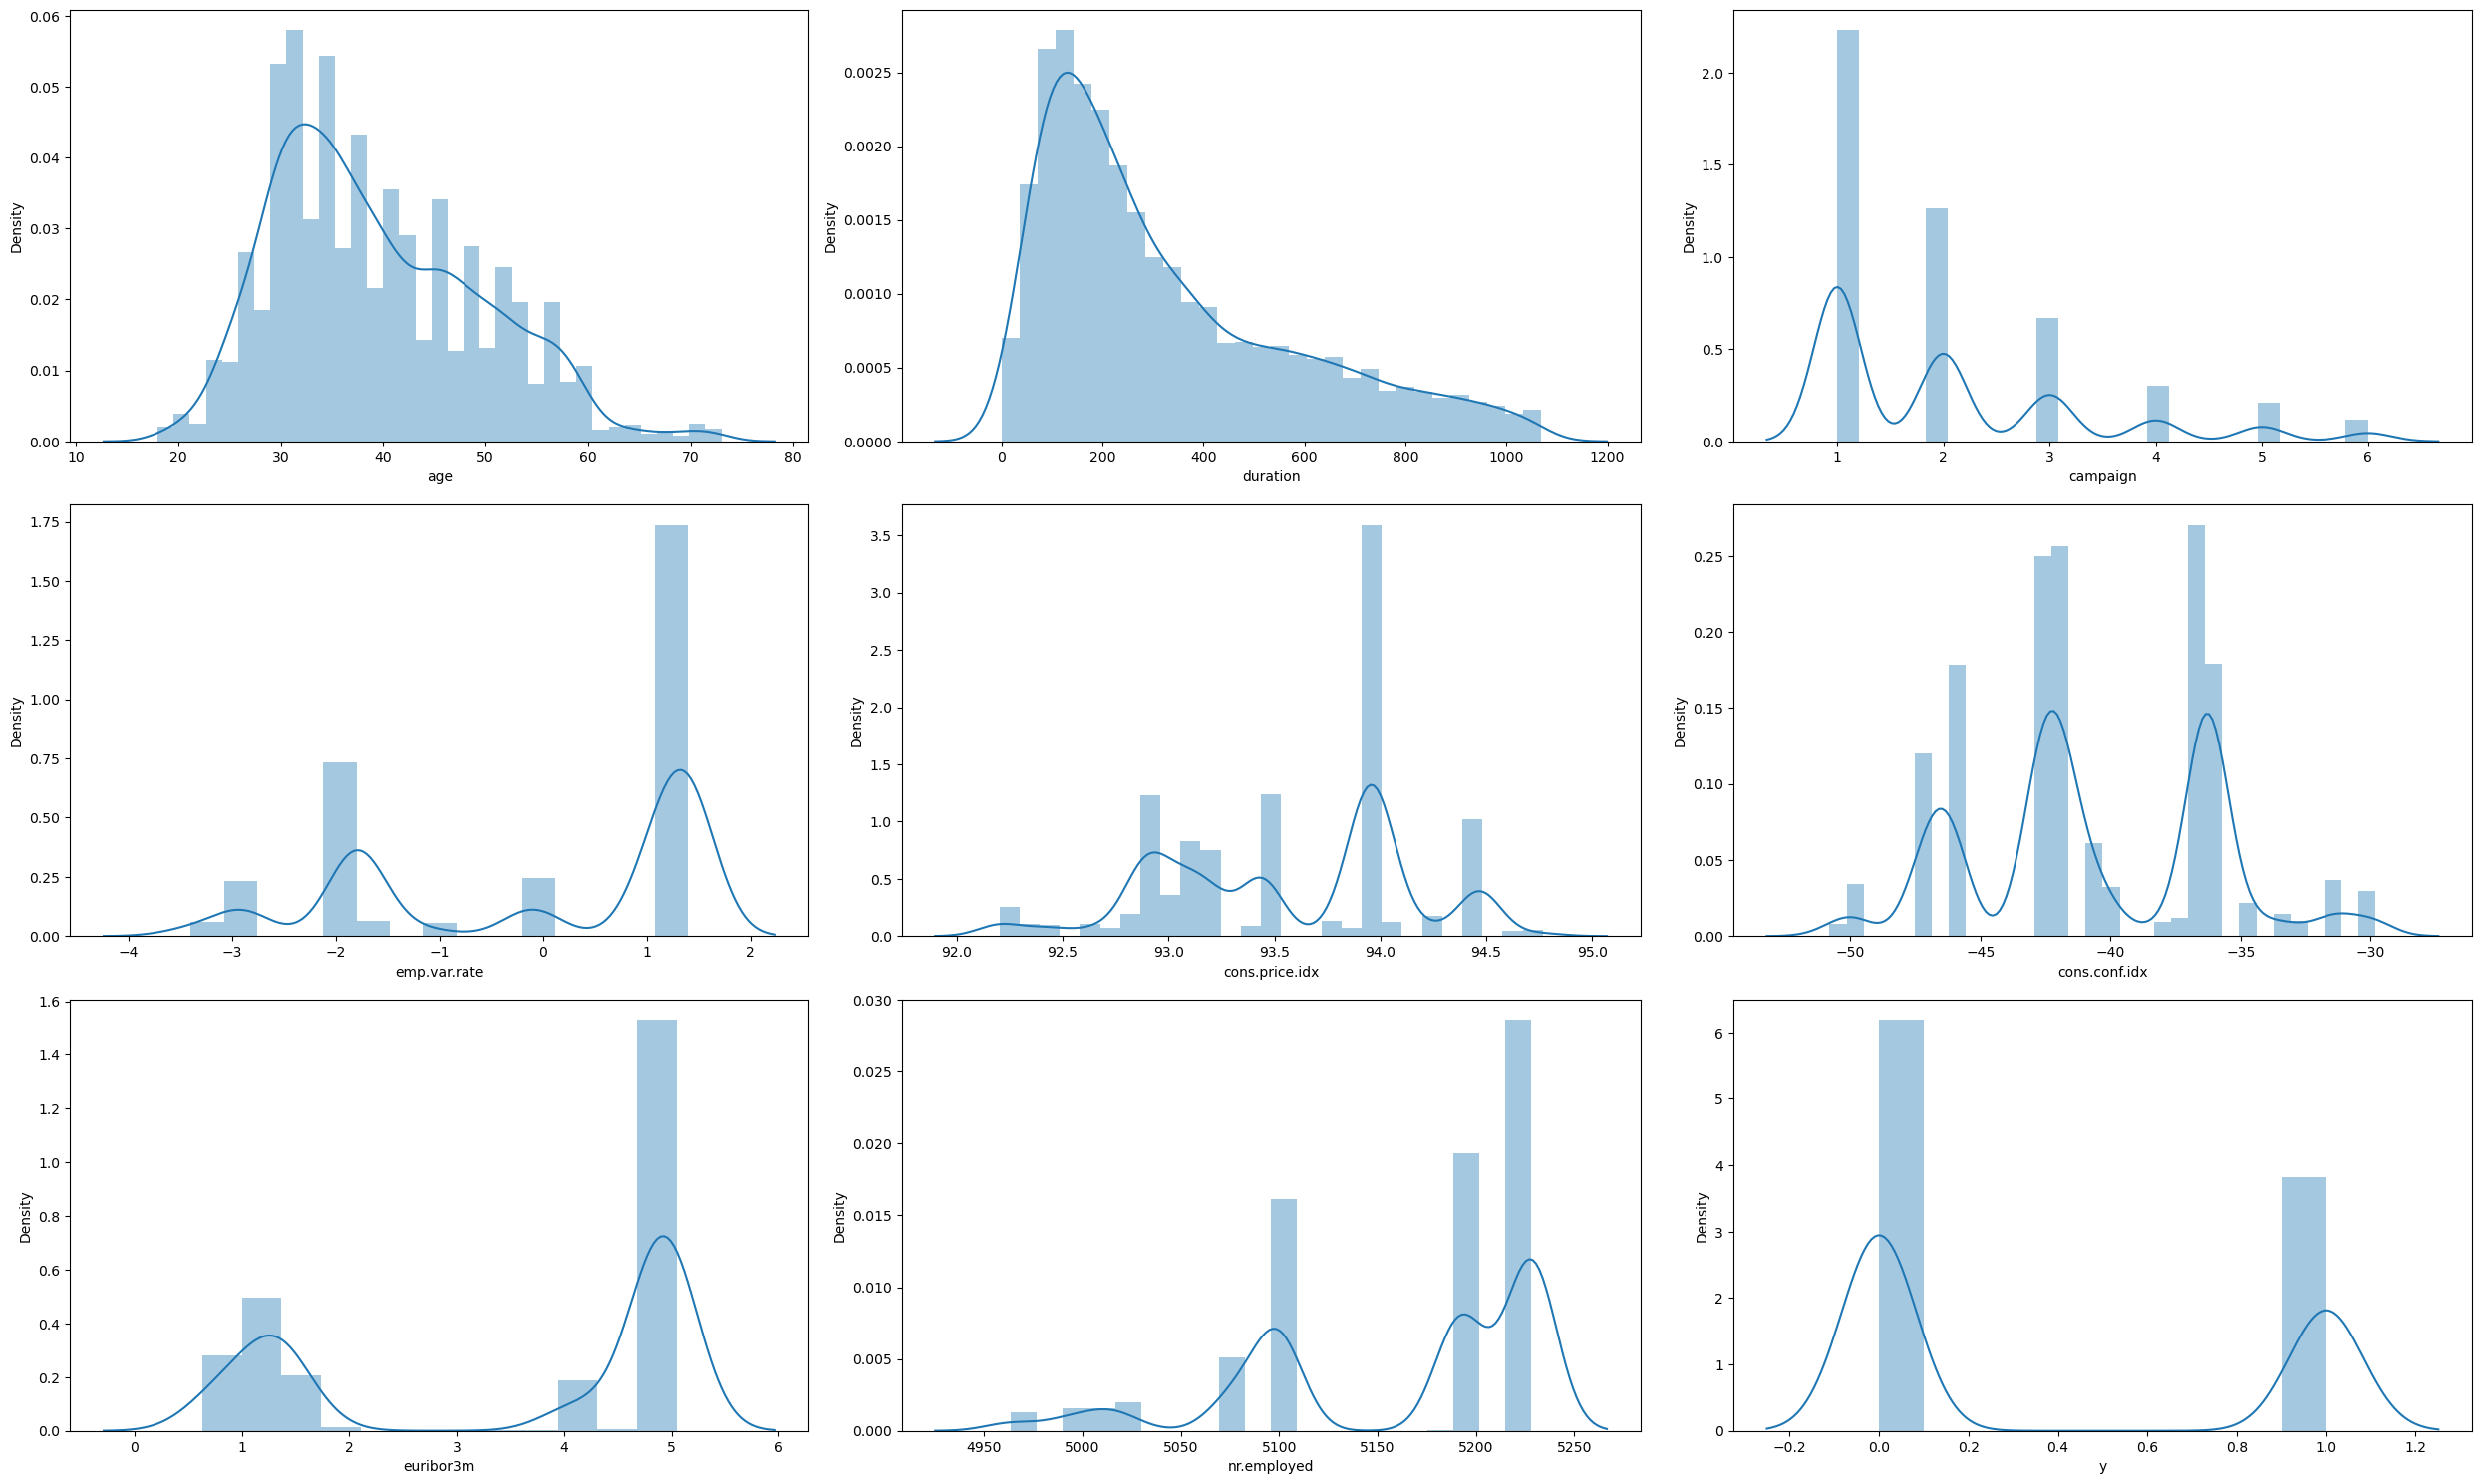

In [18]:
fig, ax = plt.subplots(3, 3, figsize=(25, 15))

for variable, subplot in zip(df, ax.flatten()):
    distplt = sns.distplot(x=df[variable], ax=subplot)
    distplt.set_xlabel(variable, fontsize = 10)
    
plt.tight_layout()   
plt.show() 

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>7. Plot the distribution of the target variable.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

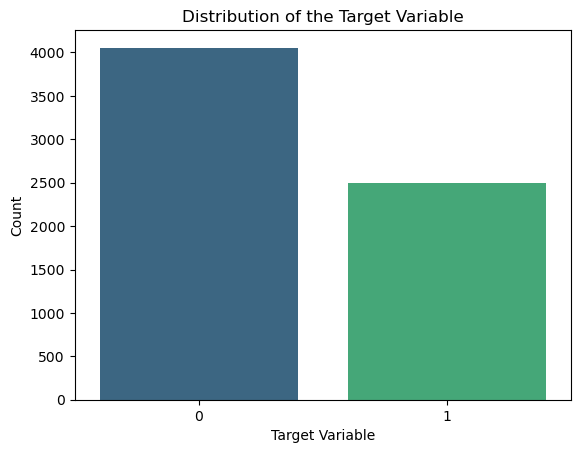

In [19]:
sns.countplot(x='y', data=df, palette='viridis')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.title('Distribution of the Target Variable')
plt.show()

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>8. Scale all the numeric variables using standard scalar.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [20]:
X=df.drop('y', axis=1)
scale=StandardScaler()
X=pd.DataFrame(scale.fit_transform(X),columns=X.columns)
X.head()

,age,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,-0.722787,-0.480765,-0.024486,0.701361,0.749298,0.910658,0.765585,0.394074
1,-1.410132,-0.330797,0.754670,-1.081276,-1.217928,-2.008221,-1.104009,-0.840708
2,-0.330018,-0.445246,-0.803642,-0.036282,-0.607764,-0.291233,0.350869,0.458567
3,0.357326,0.880787,-0.803642,0.701361,0.749298,0.910658,0.765023,0.394074
4,1.241055,-1.037225,-0.803642,0.701361,0.749298,0.910658,0.763899,0.394074


<a id="knn"> </a>
## 2. K Nearest Neighbors (KNN)

## We shall use the bank marketing dataset that we cleaned above

Before applying classification techniques to predict whether the client subscribed the term deposit or not, let us split the dataset in train and test set.

In [21]:
y=df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn_classification = KNeighborsClassifier(n_neighbors=3)
knn_model = knn_classification.fit(X_train, y_train)

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>9. Create a function to draw a confusion matrix (heatmap) and a function to plot a roc-auc curve.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

#### Define a function to plot the confusion matrix.

In [27]:
def confusion_mat(model_name,X,y,label):
    y_pred = model_name.predict(X)
    cm = confusion_matrix(y,y_pred)
    sns.heatmap(cm,annot=True)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Confusion Matrix - {label}')
    plt.show()

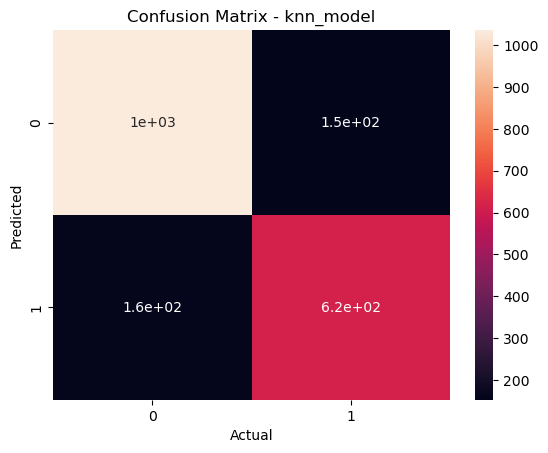

In [28]:
confusion_mat(knn_model,X_test,y_test,'knn_model')

#### Define a function to plot the ROC curve.

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [30]:
def roc_plot(model,X,y,label):
    # K Nearest Neighbors
    y_pred = model.predict_proba(X)[:,1]
    
    # The roc_curve() returns the values for false positive rate, true positive and threshold
    # pass the actual target values and predicted probabilities to the function


    fpr, tpr, thresholds = roc_curve(y, y_pred)
    auc_score = round(roc_auc_score(y, y_pred),4)

    # plot the ROC curve
    plt.plot(fpr, tpr,label = label+'(AUC Score = %0.4f)' % auc_score)

    # set limits for x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # plot the straight line showing worst prediction for the model
    plt.plot([0, 1], [0, 1],'r--')

    # add plot and axes labels
    # add plot and axes labels
    # set text size using 'fontsize
    plt.title('ROC curve for Admission Prediction Classifier (Full Model)', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

    #add the AUC score to the plot
    # 'x' and 'y' gives position of the text
    #'s' is the text
    # use round() to round-off the AUC score upto 4 digits
    plt.legend(loc = 'lower right')

    # plot the grid
    plt.grid(True)

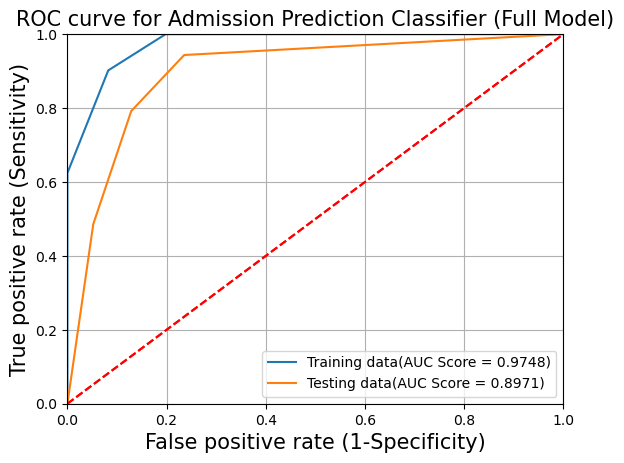

In [31]:
roc_plot(knn_model,X_train,y_train,'Training data')
roc_plot(knn_model,X_test,y_test,'Testing data')

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>10. Build a knn model on a training dataset with euclidean distance and 3 neighbours to predict whether or not the client subscribed the term deposit. Calculate the accuracy of the model.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [32]:
from sklearn.metrics import classification_report

In [33]:
knn_model_2 = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn_model = knn_model_2.fit(X_train, y_train)
train_pred=knn_model.predict(X_train)
print('Performance')
print('roc_auc_score',roc_auc_score(y_train, knn_model.predict_proba(X_train)[:,1]))
print(classification_report(train_pred ,y_train))

Performance
roc_auc_score 0.9748053392207734
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2799
           1       0.90      0.87      0.88      1789

    accuracy                           0.91      4588
   macro avg       0.91      0.90      0.91      4588
weighted avg       0.91      0.91      0.91      4588



<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>11. Plot a confusion matrix using the function created above and print a classification report. </b>
                </font>
            </div>
        </td>
    </tr>
</table>

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1189
           1       0.80      0.79      0.80       778

    accuracy                           0.84      1967
   macro avg       0.83      0.83      0.83      1967
weighted avg       0.84      0.84      0.84      1967



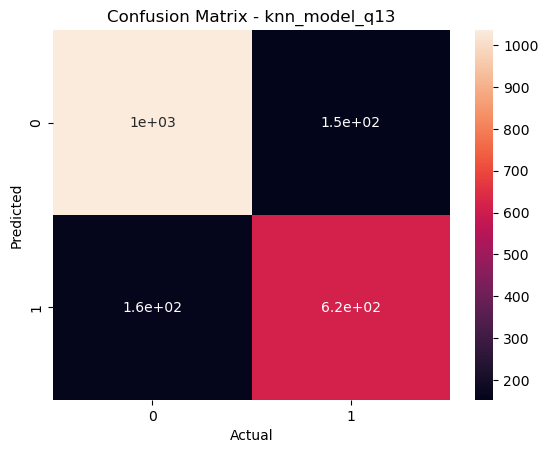

In [36]:
test_pred=knn_model.predict(X_test)
print(classification_report(y_test, test_pred))

confusion_mat(knn_model,X_test,y_test,'knn_model_q13')

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>12. Find the optimal value of 'k' in knn with 3 fold cross validation.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

Given list of values:

    n_neighbors = np.arange(1, 25, 2)
    metric = ['hamming','euclidean','manhattan','Chebyshev']

In [37]:
from sklearn.model_selection import GridSearchCV
tuning_parameters = {'n_neighbors':range(1, 25, 2), 'p':[1,2,3,4,5]}   # k_value(n_neighbors) should be odd

# instantiate the 'Classifier'
knn_model = KNeighborsClassifier()

knn_grid = GridSearchCV(estimator=knn_model, param_grid=tuning_parameters, cv=3, scoring='roc_auc')

knn_grid.fit(X_train, y_train)

print('Best parameters for classifier:', knn_grid.best_params_, '\n')
print('Best observed roc_auc:', knn_grid.best_score_)

Best parameters for classifier: {'n_neighbors': 21, 'p': 1} 

Best observed roc_auc: 0.927841241654844


<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>13.  Build a KNN model with the best parameters and find the accuracy. Also generate a classification report.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [42]:
kn = KNeighborsClassifier(n_neighbors=21,metric='manhattan')
knn_model13 = kn.fit(X_train,y_train)
y_pred13 = knn_model13.predict(X_test)

print('accuracy_score:',accuracy_score(y_test,y_pred13),'\n')
print(classification_report(y_test,y_pred13))

accuracy_score: 0.8566344687341129 

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1189
           1       0.82      0.82      0.82       778

    accuracy                           0.86      1967
   macro avg       0.85      0.85      0.85      1967
weighted avg       0.86      0.86      0.86      1967



<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>14. Find the area under the receiver operating characteristic curve and the confusion matrix for the tuned KNN model built in question 13.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

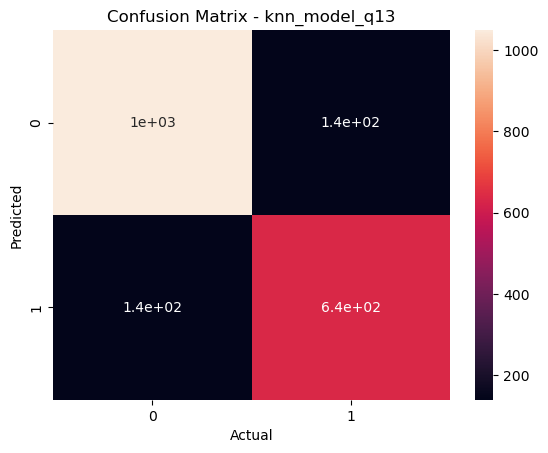

In [43]:
confusion_mat(knn_model13,X_test,y_test,'knn_model_q13')

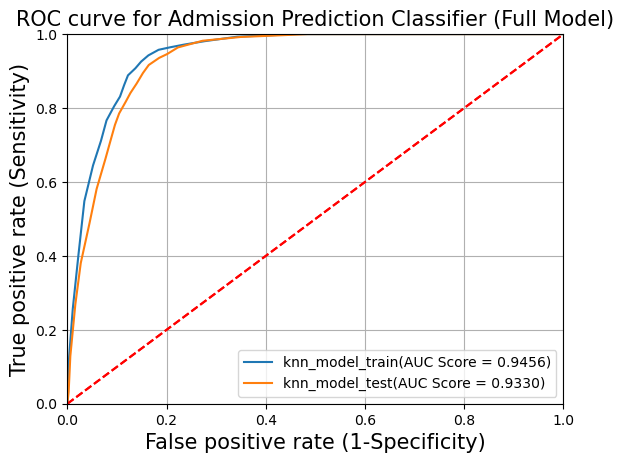

In [45]:
roc_plot(knn_model13,X_train,y_train,'knn_model_train')
roc_plot(knn_model13,X_test,y_test,'knn_model_test')

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>15. Calculate the percentage of misclassified and correctly classified observations.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [46]:
y_pred = knn_model13.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(cm)

TP = cm[1, 1]  
TN = cm[0, 0] 
FP = cm[0, 1] 
FN = cm[1, 0]

total = np.sum(cm)
percentage_misclassified = (FP + FN) / total * 100

percentage_correctly_classified = (TP + TN) / total * 100

print('Percentage of misclassified observations:', percentage_misclassified)
print('Percentage of correctly classified observations:', percentage_correctly_classified)

[[1049  140]
 [ 142  636]]
Percentage of misclassified observations: 14.336553126588713
Percentage of correctly classified observations: 85.66344687341129


<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>16. Compute the accuracy for each value of k and append the value in a list 'accuracy'. Build knn models for euclidean distance metric. Consider only the odd numbers between the range 1 and 25 for the 'k'.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [49]:
accuracy = []

for i in range (1,26,2):
    knn = KNeighborsClassifier(n_neighbors=i,p=2)
    score = cross_val_score(knn,X_train,y_train,cv = 5)
    score = score.mean()
    accuracy.append(score)

optimal_k_index = np.argmax(accuracy)
optimal_k = 2 * optimal_k_index + 1 

print(f'Accuracy for each value of k: {accuracy}','\n')
print(f'Optimal Value of k: {optimal_k}','\n')
print(f'Max Accuracy: {max(accuracy)}')

Accuracy for each value of k: [0.8232336191474046, 0.8526572630748653, 0.8659541509563962, 0.8648643511687967, 0.865953675787533, 0.8661705903735539, 0.8681337505315951, 0.8687875828872684, 0.8676984958529637, 0.8650834040147017, 0.8637747889656285, 0.8613773244666824, 0.8624671242542817] 

Optimal Value of k: 15 

Max Accuracy: 0.8687875828872684


<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>17. Draw a line plot to see the accuracy (list created in the above question) for each value of K using euclidean distance as a metric of KNN model and find the optimal value of 'k'.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

Given list of values:

    n_neighbors = np.arange(1, 25, 2)

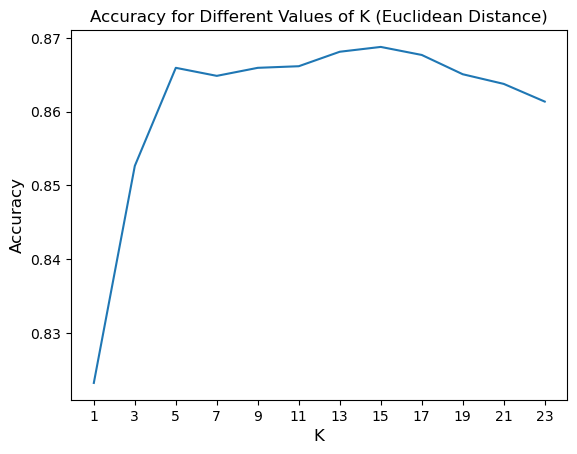

Optimal Value of 'k': 15
Maximum Accuracy: 0.8687875828872684


In [50]:
n_neighbors = np.arange(1, 25, 2)
accuracy = []

for k in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, p=2)
    score = cross_val_score(knn, X_train, y_train, cv=5)
    mean_score = score.mean()
    accuracy.append(mean_score)

# Plotting the accuracy
plt.plot(n_neighbors, accuracy)
plt.title('Accuracy for Different Values of K (Euclidean Distance)', fontsize=12)
plt.xlabel('K', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(n_neighbors)
plt.show()

# Finding the optimal value of 'k'
optimal_k = n_neighbors[np.argmax(accuracy)]
max_accuracy = max(accuracy)

print(f"Optimal Value of 'k': {optimal_k}")
print(f"Maximum Accuracy: {max_accuracy}")


<a id="nb"> </a>
## 3. Naive Bayes

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>18. Build a Gaussian naive bayes model and generate a classification report. Also tell how well is the model performing.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [51]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb_model = gnb.fit(X_train,y_train)
y_pred_train = gnb_model.predict(X_train)
y_pred_test = gnb_model.predict(X_test)
print('Train Report','\n')
print(classification_report(y_train,y_pred_train),'\n')
print('Test Report','\n')
print(classification_report(y_test,y_pred_test))

Train Report 

              precision    recall  f1-score   support

           0       0.86      0.77      0.81      2866
           1       0.67      0.79      0.73      1722

    accuracy                           0.78      4588
   macro avg       0.77      0.78      0.77      4588
weighted avg       0.79      0.78      0.78      4588
 

Test Report 

              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1189
           1       0.71      0.80      0.75       778

    accuracy                           0.79      1967
   macro avg       0.78      0.79      0.78      1967
weighted avg       0.80      0.79      0.79      1967



- The model is achieving consistent performance on both the training and test sets, as evidenced by similar precision, recall, and F1-score values.

- The macro and weighted averages are also consistent, indicating a balanced performance across classes.

- The overall accuracy of the model on both the training and test sets is 78%, suggesting that the model is making accurate predictions on new, unseen data.

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>19. Find the area under the receiver operating characteristic curve and the confusion matrix for the Naive Bayes model built in question 18.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

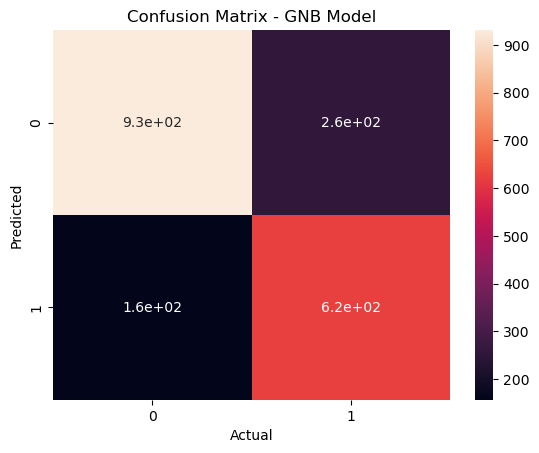

In [52]:
confusion_mat(gnb_model,X_test,y_test,'GNB Model')

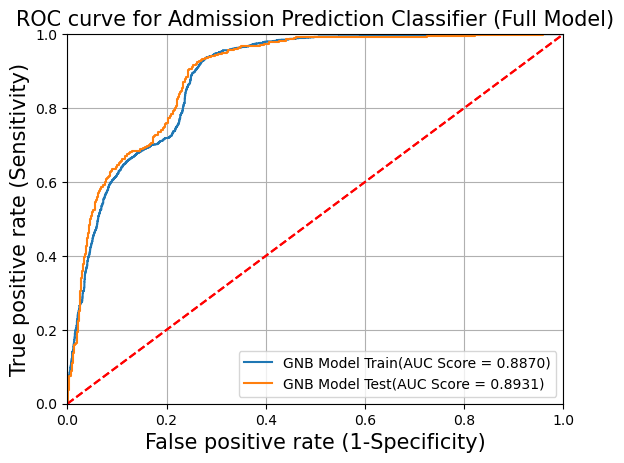

In [54]:
roc_plot(gnb_model,X_train,y_train,'GNB Model Train')
roc_plot(gnb_model,X_test,y_test,'GNB Model Test')

- AUC Score for both Training and Testing set is high. So model performanace is good.

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>20. Build a Gaussian Naive Bayes model and perform 10 fold cross validation and find the average accuracy.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [55]:
gnb = GaussianNB()
scores = cross_val_score(gnb,X_train,y_train,cv=10)

average_accuracy = np.mean(scores)

print("Cross-Validation Scores:", scores,'\n')
print("Average Accuracy:", average_accuracy)

Cross-Validation Scores: [0.77995643 0.77777778 0.80610022 0.74291939 0.76688453 0.75381264
 0.77559913 0.79520697 0.78165939 0.79039301] 

Average Accuracy: 0.7770309482356745
